In [4]:
import sys
sys.path.append(r"f:\\Data_Science_Learning")

In [5]:
import random 
from library.Probability import inverse_normal_cdf
from library.Statistics import correlation, mean, standard_deviation, variance
from library.Linear_Algebra import Matrix, Vector, make_matrix, vector_mean, substract, dot, magnitude, scalar_multiply
from typing import List, Tuple, Dict
from collections import Counter, defaultdict
import math
import matplotlib.pyplot as plt
import datetime

# One-Dimensional Data

In [6]:
def bucketsize(point:float, bucket_size:float) -> float:
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point/bucket_size)

def make_histogram(points:List[float], bucket_size:float) -> Counter:
    """Buckets the points and counts how many in each bucket"""
    return Counter(bucketsize(point, bucket_size) for point in points)

def plot_histogram(points:List[float], bucket_size:float, title:str="") -> None:
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)


In [7]:
random.seed(0)

# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(100000)] 

# normal distribution with mean 0, standard deviation 57

normal = [57 * inverse_normal_cdf(random.random()) for _ in range(100000)]



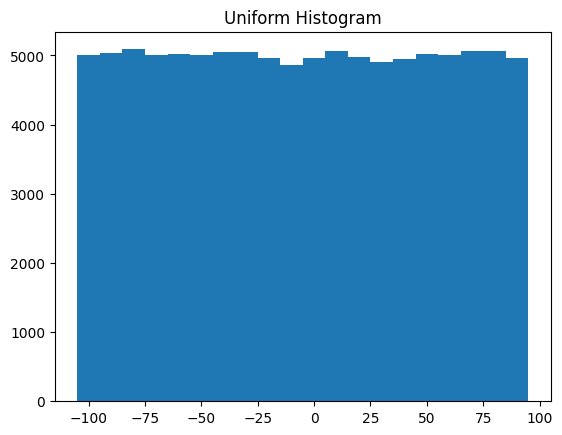

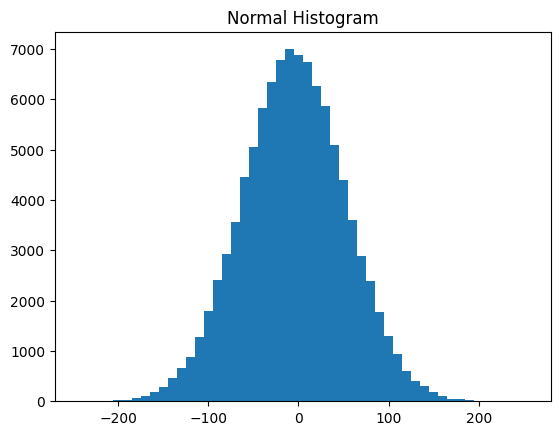

In [8]:
plot_histogram(uniform, 10, "Uniform Histogram")
plt.show()

plot_histogram(normal, 10, "Normal Histogram")
plt.show()

In [9]:
def random_normal() -> float:
    """Returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

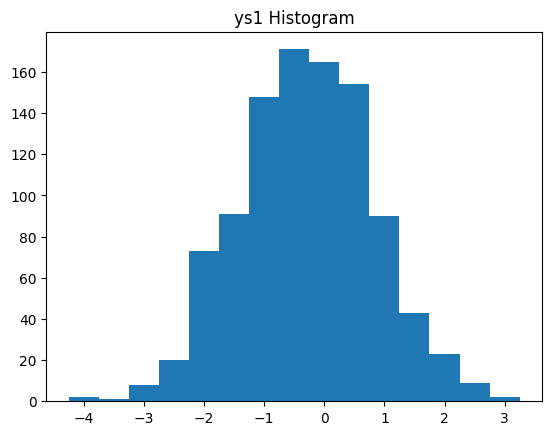

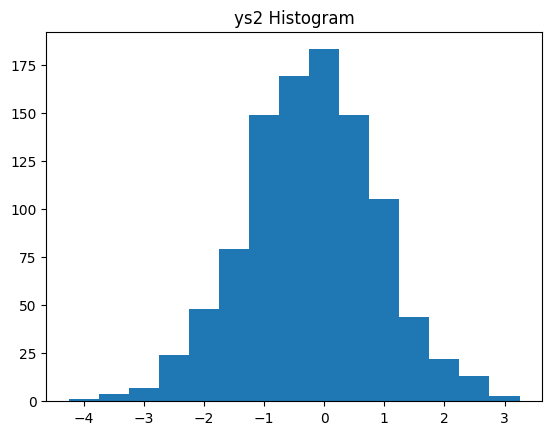

In [10]:



xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

plot_histogram(ys1, 0.5, "ys1 Histogram")
plt.show()

plot_histogram(ys2, 0.5, "ys2 Histogram")
plt.show()



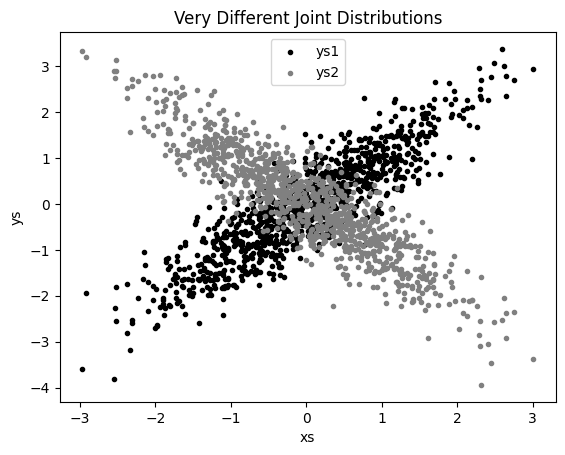

In [11]:

plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()


In [12]:
print(correlation(xs, ys1))
print(correlation(xs, ys2))

0.8912423120878924
-0.8956672207843116


In [13]:
def correlation_matrix(data:List[Vector]) -> Matrix:
    """Returns the len(data) x len(data) matrix whose (i, j)-th entry
    is the correlation between data[i] and data[j]"""
    def correlation_ij(i:int, j:int) -> float:
        return correlation(data[i], data[j])
    return make_matrix(len(data), len(data), correlation_ij)

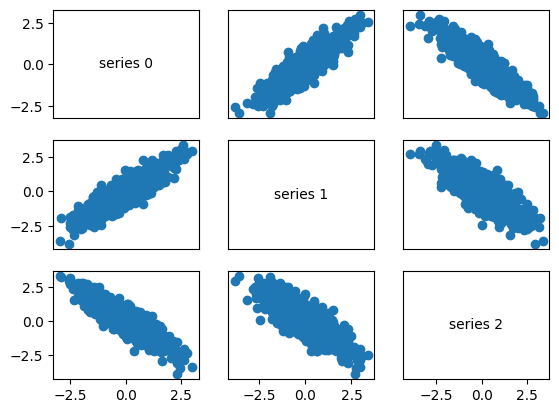

In [14]:
# corr_data is a list of three 100-d vectors
corr_data = [xs, ys1, ys2]

num_vectors = len(corr_data)
fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):
        # scatter column_j on the x-axis vs column_i on the y-axis
        if i != j: ax[i][j].scatter(corr_data[j], corr_data[i])
        # unless i == j, in which case show the series name
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                xycoords='axes fraction',
                                ha="center", va="center")
        # then hide axis labels except left and bottom charts
        if i < num_vectors - 1 : ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)

# fix the bottom right and top left axis labels, which are wrong because
# their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())
plt.show()

In [15]:
from collections import namedtuple

StockPrice = namedtuple("StockPrice", ['symbol', 'date', 'closing_price'])
price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

In [16]:
from typing import NamedTuple

class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']
    
price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == "MSFT"
assert price.closing_price == 106.03
assert price.is_high_tech()

In [17]:
from dataclasses import dataclass

@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']
    
price2 = StockPrice2('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price2.symbol == "MSFT"
assert price2.closing_price == 106.03
assert price2.is_high_tech()


# Cleaning and Munging

In [18]:
from dateutil.parser import parse

def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row
    return StockPrice(symbol=symbol,
                      date=parse(date).date(),
                      closing_price=float(closing_price))

stock = parse_row(["MSFT", "2018-12-14", "106.03"])

assert stock.symbol == "MSFT"
assert stock.date == datetime.date(2018, 12, 14)
assert stock.closing_price == 106.03


    What happens if a 'bad' data is pass in

In [19]:
from typing import Optional
import re

def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row

    # Stock symbol should be all capital letters
    if not re.match(r"^[A-Z]+$", symbol):
        return None

    try:
        date = parse(date_).date()
    except ValueError:
        return None

    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None

    return StockPrice(symbol, date, closing_price)

# Should return None for errors
assert try_parse_row(["MSFT0", "2018-12-14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12--14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12-14", "x"]) is None
# But should return same as before if data is good
assert try_parse_row(["MSFT", "2018-12-14", "106.03"]) == stock

In [20]:
import csv

data: List[StockPrice] = []

with open("LearnNTest.txt") as f:
    reader = csv.reader(f)
    for row in reader:
        maybe_stock = try_parse_row(row)
        if maybe_stock is None:
            print(f"Skipping invalid row: {row}")

        else:
            data.append(maybe_stock)

FileNotFoundError: [Errno 2] No such file or directory: 'LearnNTest.txt'

# Manipulating data

In [ ]:
data =[
    StockPrice(symbol="AAPL", date=datetime.date(2014, 6, 20), closing_price=90.91),
    StockPrice(symbol="MSFT", date=datetime.date(2014, 6, 20), closing_price=41.68),
    StockPrice(symbol="FB", date=datetime.date(2014, 6, 20), closing_price=64.5),
    StockPrice(symbol="AAPL", date=datetime.date(2014, 6, 19), closing_price=91.86),
    StockPrice(symbol="MSFT", date=datetime.date(2014, 6, 19), closing_price=float('nan')),
    StockPrice(symbol="FB", date=datetime.date(2014, 6, 19), closing_price=64.34)
]

max_appl_price = max(stock_price.closing_price 
                     for stock_price in data 
                     if stock_price.symbol == "AAPL")

In [ ]:
from collections import defaultdict


max_price : Dict[str, float] = defaultdict(lambda: float('-inf'))

for sp in data:
    symbol, closing_price = sp.symbol, sp.closing_price
    if closing_price > max_price[symbol]:
        max_price[symbol] = closing_price

In [ ]:
prices: Dict[str, List[StockPrice]] = defaultdict(list)

for sp in data:
    prices[sp.symbol].append(sp)

#Order the prices by date
prices = {symbol: sorted(symbol_prices) 
          for symbol, symbol_prices in prices.items()}
print(prices)

In [ ]:
def pct_change(yesterday: StockPrice, today: StockPrice) -> float:
    return today.closing_price / yesterday.closing_price - 1

class DailyChange(NamedTuple):
    symbol: str
    date: datetime.date
    pct_change: float

def day_over_day_changes(prices: List[StockPrice]) -> List[DailyChange]:
    """
    Assumes prices are for one stock and are in order
    """
    return [DailyChange(symbol=today.symbol,
                        date=today.date,
                        pct_change=pct_change(yesterday, today))
            for yesterday, today in zip(prices, prices[1:])]

all_changes = [change 
               for symbol_prices in prices.values()
               for change in day_over_day_changes(symbol_prices)]

In [ ]:
max_change = max(all_changes, key=lambda change: change.pct_change)
print(max_change)

min_change = min(all_changes, key=lambda change:change.pct_change)
print(min_change)

In [ ]:
changes_by_month: List[DailyChange] = {month: [] for month in range(1, 13)}

for change in all_changes:
    changes_by_month[change.date.month].append(change)

avg_daily_change = {}

for month, changes in changes_by_month.items():
    if len(changes)==0: break
    else:
        avg_daily_change[month] = sum(change.pct_change for change in changes) / len(changes)

print(avg_daily_change)

# Rescaling

In [ ]:
def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """Returns the mean and standard deviation for each position"""
    dim = len(data[0])

    mean = vector_mean(data)
    stdevs = [standard_deviation([vector[i] for vector in data]) for i in range(dim)]

    return mean, stdevs

vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)

assert means == [-1, 0, 1]
assert stdevs == [2, 1, 0]


In [ ]:
def rescale(data: List[Vector]) -> List[Vector]:
    """
    Rescales the input data so that each position has mean 0 and standard deviation 1
    (Leaves a position as is if its standard deviation is 0)
    """


    dim = len(data[0])
    mean, stdevs = scale(data)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]

    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - mean[i]) / stdevs[i]

    return rescaled

data = rescale(vectors)
print(data)

In [ ]:
import tqdm

for i in tqdm.trange(100):
    _ = [random.random() for _ in range(1000000)]


In [ ]:
def primes_up_to(n: int) -> List[int]:
    primes = [2]

    with tqdm.trange(3, n) as t:
        for i in t:
            # i is prime if no smaller prime divides it
            i_is_prime = not any(i % p == 0 for p in primes)
            if i_is_prime:
                primes.append(i)

            t.set_description(f"{len(primes)} primes")

    return primes

my_primes = primes_up_to(10_000)

# Dimensionality Reduction

In [ ]:
def de_mean(data: List[Vector]) -> List[Vector]:
    """Recenters that data to have mean of 0 in every dimension"""

    mean = vector_mean(data)
    return [substract(vector, mean) for vector in data]


In [ ]:
def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

In [ ]:
def directional_variance(data: List[Vector], w: Vector) -> float:
    """ Returns the variance of x in the direction of w"""

    w_dir = direction(w)
    return sum(dot(v, w_dir) **2 for v in data)

In [ ]:
def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """The gradient of directional variance with respect to w"""

    w_dir = direction(w)
    return [sum(2 * dot(v, w_dir) * v[i] for v in data)
            for i in range(len(w))]

In [ ]:
from library.GradientDescent import gradient_step

def first_principal_component(data: List[Vector], n: int = 100, step_size: float = 0.1) -> Vector:
    # Start with a random guess
    guess = [1.0 for _ in data[0]]

    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, -step_size)
            t.set_description(f"dv: {dv:.3f}")

    return direction(guess)

In [ ]:
def project(v: Vector, w: Vector) -> Vector:
    """Return the projection of v onto the direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    return [substract(v, project(v, w)) for v in data]

In [ ]:
def principal_component_analysis(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)

    return components

In [ ]:
def transform_vector(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]